In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch as pt
import csv
import pickle #to save notebook at sessions


#from Bojar lab format
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

#set path for pickles to be saved in
pickle_path = '/Users/erikazhang/Dropbox (MIT)/20.440 Biological Networks/project/python pickles/'
output_path = '/Users/erikazhang/Dropbox (MIT)/20.440 Biological Networks/project/output/LN output/'

In [2]:
# make dataframe comparing different transformation types
cols = {"Transformation": [], "PHA-L high accuracy": [], 
        "PHA-L low accuracy": [], "Overall accuracy": [], 'Top 5 features': []}
norm_comp = pd.DataFrame(columns = cols)

## 3. Random Forest Clustering using all T-cells from LN and Robust scaled data
to build model(S) --> build on all T-cells, and then by T-cell subtypes
https://github.com/BojarLab/scGlycomics_b16_branching/blob/main/Random%20Forest%20-%20Apr%208%202022%20-%20RQ.ipynb

In [3]:
'''Load glycosorted RAW dataframe from pickle, saved from glycogene filtering raw.ipynb
Dataframes have:
- gene names as columns (243 glycogenes) + columns for type, biotin count, PHA-L score =246 columns total
- cell barcodes as row index, for cells identified as TILs via ProjecTILs package in R
'''
# open via: 
#load updated df from pickle

pickle_in = open(pickle_path +"robust_LN.pkl","rb")
robust_LN = pickle.load(pickle_in)

In [4]:
#make copies of dataframes to not accidentally change original df
glycoLN_Z = robust_LN.copy()

In [5]:
housekeeping_list = ['Ahsa1', 'Api5', 'Atp6v1e1', 'Bcap31', 'Cops6', 'Csnk2b', 'Eif3i', 'Eif4g2', 'Gdi2', 'Hnrnpf', 
                     'Hnrnph1', 'Hnrnph2', 'Ilf2', 'Dnajc5', 'Ncl', 'Otub1', 'Pdap1', 'Polr2f', 'Rhoa', 'Srp14', 
                     'Srrm1', 'Timm44', 'Ttc1', 'Ywhab', 'Pdcd6']
cols_to_remove = set(glycoLN_Z.columns).intersection(housekeeping_list)
glycoLN_Z.drop(columns=cols_to_remove, inplace=True)

In [6]:
'''
Generate training, validation, and test set from original full df using scikit learn 
TIL ver.
'''
#y: PHA-L score array
y = glycoLN_Z['PHA-L'].values 

#X: glycogene transcript data array
x = glycoLN_Z.iloc[:, :-3].values

# Split training, validation and test set
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.1, random_state=42, stratify=y)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

In [7]:
# Parameters for grid search

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(200, 800, step=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(10, 50, step=10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [16]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.fit_transform(y_val)
y_test = encoder.fit_transform(y_test)

In [9]:
''''Use RandomSearchCV to optimize hyperparameters'''
#takes a while to run!!
model = RandomForestClassifier()

model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, 
                                  n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)

model_random.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700]},
                   random_state=42, verbose=5)

In [10]:
# Return the best estimator
LNmodel_all_robust = model_random.best_estimator_
LNmodel_all_robust.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 700,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [11]:
# save pickle 
with open(pickle_path + 'LNmodel_all_robust.pkl', 'wb') as f:
    pickle.dump(LNmodel_all_robust, f)

f.close()

# open via: 
# #load updated df from pickle
# pickle_in = open("pickle_path + LNmodel_all_robust.pkl","rb")
# LNmodel_all_robust = pickle.load(pickle_in)

In [12]:
def model_evaluation(model, x, y):
    print(f"Accuracy for 'PHA-L high' class: {100*(model.score(x[y==1], y[y==1])):>4f}%")
    print(f"Accuracy for 'PHA-L low' class: {100*(model.score(x[y==0], y[y==0])):>4f}%")
    print(f"Overall accuracy: {100*(model.score(x, y)):>4f}%")

    model_predict = model.predict(x)
    model_predict_prob = model.predict_proba(x)
    
    high = f"{100*(model.score(x[y==1], y[y==1])):>4f}%"
    low = f'{100*(model.score(x[y==0], y[y==0])):>4f}%'
    total = f'{100*(model.score(x, y)):>4f}%'

    print(f"Average loss: {log_loss(y, model_predict_prob):>4f}")
    print(f"ROC Curve AUC: {roc_auc_score(y, model_predict):>4f}")
    print(f"F1 score: {f1_score(y, model_predict):>4f}")
    return high, low, total

In [13]:
#training set
model_evaluation(LNmodel_all_robust, x_train, y_train)

Accuracy for 'PHA-L high' class: 97.064935%
Accuracy for 'PHA-L low' class: 99.894124%
Overall accuracy: 98.466177%
Average loss: 0.224387
ROC Curve AUC: 0.984795
F1 score: 0.984587


('97.064935%', '99.894124%', '98.466177%')

In [14]:
#validation   
model_evaluation(LNmodel_all_robust, x_val, y_val)

Accuracy for 'PHA-L high' class: 73.416407%
Accuracy for 'PHA-L low' class: 81.779661%
Overall accuracy: 77.556371%
Average loss: 0.491014
ROC Curve AUC: 0.775980
F1 score: 0.767644


('73.416407%', '81.779661%', '77.556371%')

In [17]:
#test set
high, low, total = model_evaluation(LNmodel_all_robust, x_test, y_test)

Accuracy for 'PHA-L high' class: 75.700935%
Accuracy for 'PHA-L low' class: 83.809524%
Overall accuracy: 79.716981%
Average loss: 0.478886
ROC Curve AUC: 0.797552
F1 score: 0.790244


In [18]:
#extract top 5 important genes and append to dataframe 
feature_importances = pd.DataFrame({'feature': glycoLN_Z.columns[:-3], 
                                    'importance': LNmodel_all_robust.feature_importances_})

# Sort the dataframe by importance score in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances['combo'] = feature_importances['feature'] + ': '+ feature_importances['importance'].round(4).astype(str)

# make new column that combines feature name with its importance value, get top 5 as string to add to dictionary
top10p_df = feature_importances.head(26)
top10p = str(list(top10p_df['combo']))
norm_comp.loc[len(norm_comp.index)] = ['Robust scaler', high, low, total, top10p] 


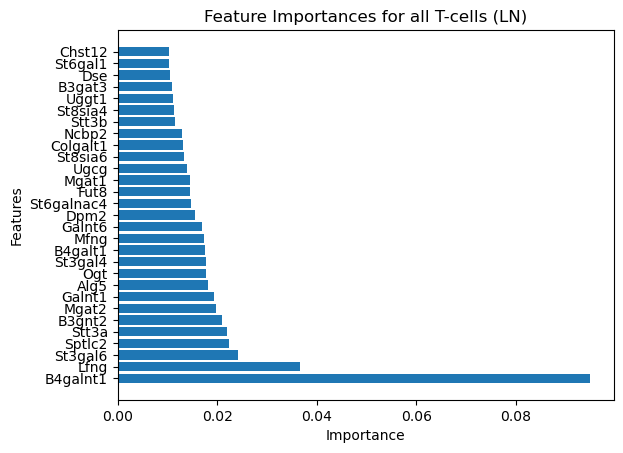

In [19]:
#plot feature importances for all TIL T-cells normalized via robust
robust_featimp = feature_importances[['feature', 'importance']]
robust_featimp = robust_featimp.sort_values(by='importance', ascending=False).head(30)
values = list(robust_featimp['importance'])
column_names = list(robust_featimp['feature'])
fig, ax = plt.subplots()
ax.barh(column_names, values)

ax.set_title('Feature Importances for all T-cells (LN)')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')

plt.show()
ax.figure.savefig('/Users/erikazhang/Dropbox (MIT)/20.440 Biological Networks/project/output/feature importances for all LN t-cells(robust)')

In [20]:
pd.set_option('display.max_colwidth', None)

norm_comp.to_csv('/Users/erikazhang/Dropbox (MIT)/20.440 Biological Networks/project/output/LNrobust_nohousekeeping.csv', index=False)
norm_comp

,Transformation,PHA-L high accuracy,PHA-L low accuracy,Overall accuracy,Top 5 features
0,Robust scaler,75.700935%,83.809524%,79.716981%,"['B4galnt1: 0.0949', 'Lfng: 0.0366', 'St3gal6: 0.0242', 'Sptlc2: 0.0225', 'Stt3a: 0.022', 'B3gnt2: 0.021', 'Mgat2: 0.0198', 'Galnt1: 0.0194', 'B3gnt2: 0.0193', 'Alg5: 0.0181', 'Ogt: 0.0177', 'St3gal4: 0.0177', 'B4galt1: 0.0176', 'Mfng: 0.0173', 'Galnt6: 0.017', 'Dpm2: 0.0154', 'St6galnac4: 0.0147', 'Fut8: 0.0145', 'Mgat1: 0.0145', 'Ugcg: 0.0139', 'St8sia6: 0.0133', 'Colgalt1: 0.0132', 'Ncbp2: 0.0129', 'Stt3b: 0.0115', 'St8sia4: 0.0113', 'Uggt1: 0.011']"


## 3B. Random Forest using Robust Scaler isolating each T-cell subtype (comparison)

In [21]:
pickle_in = open(pickle_path + "glycoLN_df.pkl","rb")
glycoLN_df = pickle.load(pickle_in)

### use dataframe of raw gene expression with biotin and type info

In [22]:
# Transpose matrix for easy sorting
glycoLN_df = glycoLN_df.transpose()

#Sort the cells based on their biotin values
final_LN_df = glycoLN_df.sort_values(by='Biotin_hash', ascending = False)
final_LN_df

,Ahsa1,Api5,Atp6v1e1,Bcap31,Cops6,Csnk2b,Eif3i,Eif4g2,Gdi2,Hnrnpf,...,Galntl6,Galntl5,Galnt13,Galnt15,Galnt14,Dse,Dsel,Glce,Biotin_hash,Type
AACTTTCGTCGCGAAA-1,0,0,0,0,0,0,0,2,1,1,...,0,0,0,0,0,0,0,0,28003,CD8_Tex
AGGGATGAGCCCGAAA-1,0,0,0,2,1,1,5,0,1,3,...,0,0,0,0,0,0,0,0,22889,CD8_NaiveLike
ACTATCTTCATTCACT-1,1,3,1,3,1,5,7,7,6,9,...,0,0,0,0,0,0,0,0,18490,Treg
TTCTCAACATGGAATA-1,1,0,1,0,0,1,3,2,1,5,...,0,0,0,0,0,1,0,0,18417,CD8_NaiveLike
ACTGAACTCGTTGCCT-1,0,1,0,3,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,17809,Treg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGATTGCCACGAAGCA-1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,16,CD8_NaiveLike
GGCGTGTAGGGATCTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14,CD8_NaiveLike
CGTCTACTCAGCCTAA-1,1,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,10,CD8_NaiveLike
GCTGGGTCACCGGAAA-1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,10,CD8_NaiveLike


### split dataframe into subtypes

In [23]:
'''
SPLIT
'''
# Get list of T-cell subtypes for which to make a dataframe for TILs
tcell_subtypes = final_LN_df['Type'].unique()

#make dataframe names for later access
df_names = [i+'_df' for i in list(tcell_subtypes)]

# Make copy of original df just in case
split_df = final_LN_df.copy()

LNcell_dfs_sub = {}

# Make separate dataframe containing data for each t-cell subtype
for cell_type, name in zip(tcell_subtypes, df_names):
    LNcell_dfs_sub[name] = split_df[split_df['Type'] == cell_type]


In [24]:
# save pickle 
with open(pickle_path + 'LNcell_dfs_sub.pkl', 'wb') as f:
    pickle.dump(LNcell_dfs_sub, f)  

# f.close()

# open via: 
# #load updated df from pickle
# pickle_in = open(pickle_path + "LNcell_dfs_sub.pkl","rb")
# LNcell_dfs_sub = pickle.load(pickle_in)


In [25]:
# #extracting all dataframes from df dictionary
# CD8_NaiveLike_df= TILtcell_dfs_sub['CD8_NaiveLike_df']
# CD8_EffectorMemory_df = TILtcell_dfs_sub['CD8_EffectorMemory_df']
# Th1_df = TILtcell_dfs_sub['Th1_df']
# CD8_EarlyActiv_df = TILtcell_dfs_sub['CD8_EarlyActiv_df']
# Treg_df = TILtcell_dfs_sub['Treg_df']
# CD8_Tex_df = TILtcell_dfs_sub['CD8_Tex_df']
# CD4_NaiveLike_df = TILtcell_dfs_sub['CD4_NaiveLike_df']
# Tfh_df = TILtcell_dfs_sub['Tfh_df']
# CD8_Tpex_df = TILtcell_dfs_sub['CD8_Tpex_df']

### For each dataframe subtype, do robust scaler normalization and add glycogene scores

In [26]:
# Function: determine PHA-L read cut-offs for binary classification FROM BOJAR LAB
def categorize_lectin(data_all, quantile_high, quantile_low, ref_col_loc):
    cutoff = np.quantile(data_all.loc[:,ref_col_loc], [quantile_high, quantile_low], interpolation="nearest").tolist()

    print(f"Cut-off for PHA-L high: {cutoff[0]}; Cut-off for PHA-L low: {cutoff[1]}")

    high_indices = np.array(data_all.loc[:,ref_col_loc]>=cutoff[0])
    low_indices = np.array(data_all.loc[:,ref_col_loc]<cutoff[1])
    high_low_indices = np.logical_or(high_indices, low_indices)

    high_count = high_indices.sum()
    low_count = low_indices.sum()

    return cutoff, [high_indices, low_indices, high_low_indices], [high_count, low_count]

In [27]:
'''
Do normalization via robust scaler for each df
Assign L-PHA score to each, and only keep the '''

# Parameters for categorize lectin function
quantile_high, quantile_low = 0.75, 0.25
ref_col = 'Biotin_hash' #last column of dataframes contain biotin info


name_list = list(LNcell_dfs_sub.keys())
glycoscored_dict = {}
for name in name_list:
    #do normalization
    toy_df = LNcell_dfs_sub[name].transpose()
    toy_df = toy_df.iloc[:-2]
    cols_to_standardize = toy_df.columns
    scaler = RobustScaler()
    toy_df_LN = toy_df.copy()
    toy_df_LN[cols_to_standardize] = scaler.fit_transform(toy_df[cols_to_standardize])
    c = toy_df_LN.transpose()

    biotin_type = LNcell_dfs_sub[name].iloc[:, -2:]

    ##Add back biotin values for L-PHA scoring
    c = pd.concat([c,biotin_type], axis=1)
    
    cutoff, indices, count = categorize_lectin(c, quantile_high, quantile_low, ref_col)

    # Assign 1 to top 25% and 0 to bottom 25%
    c.loc[indices[0], "PHA-L"] = 1
    c.loc[indices[1], "PHA-L"] = 0

    # Drop the middle two quartiles
    glycoscored_dict[name]=c.loc[indices[2], :]
    
    ##take out housekeeping genes
    housekeeping_list = ['Ahsa1', 'Api5', 'Atp6v1e1', 'Bcap31', 'Cops6', 'Csnk2b', 'Eif3i', 'Eif4g2', 'Gdi2', 'Hnrnpf', 
                     'Hnrnph1', 'Hnrnph2', 'Ilf2', 'Dnajc5', 'Ncl', 'Otub1', 'Pdap1', 'Polr2f', 'Rhoa', 'Srp14', 
                     'Srrm1', 'Timm44', 'Ttc1', 'Ywhab', 'Pdcd6']
    cols_to_remove = set(glycoscored_dict[name].columns).intersection(housekeeping_list)
    glycoscored_dict[name].drop(columns=cols_to_remove, inplace=True)
    
#glycoscored_dict is now a dictionary with name of df as key and normalized df as values
# save pickle 
with open(pickle_path + 'glycoscored_dict_LNsub.pkl', 'wb') as f:
    pickle.dump(glycoscored_dict, f)

/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/1501608089.py:3: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  cutoff = np.quantile(data_all.loc[:,ref_col_loc], [quantile_high, quantile_low], interpolation="nearest").tolist()
/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/3234920947.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glycoscored_dict[name].drop(columns=cols_to_remove, inplace=True)


Cut-off for PHA-L high: 1691; Cut-off for PHA-L low: 624
[CV 3/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.783 total time=   9.7s
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.779 total time=  14.1s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.796 total time=   7.3s
[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.782 total time=   6.7s
[CV 1/5] END max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.795 total time=   6.9s
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.785 total time=   8.1s
[CV 5/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.789 total time=  10.2s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.779 total time=   3.2s

[CV 1/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.794 total time=   8.7s
[CV 4/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.789 total time=  21.0s
[CV 5/5] END max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.787 total time=   5.8s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.780 total time=  10.9s
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.781 total time=   8.1s
[CV 4/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=0.782 total time=  10.1s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.783 total time=   3.2s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.787 total time=   3.3s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_sampl

/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/1501608089.py:3: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  cutoff = np.quantile(data_all.loc[:,ref_col_loc], [quantile_high, quantile_low], interpolation="nearest").tolist()
/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/3234920947.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glycoscored_dict[name].drop(columns=cols_to_remove, inplace=True)


Cut-off for PHA-L high: 253; Cut-off for PHA-L low: 126


/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/1501608089.py:3: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  cutoff = np.quantile(data_all.loc[:,ref_col_loc], [quantile_high, quantile_low], interpolation="nearest").tolist()
/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/3234920947.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glycoscored_dict[name].drop(columns=cols_to_remove, inplace=True)
/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/1501608089.py:3: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=

Cut-off for PHA-L high: 2011; Cut-off for PHA-L low: 579
Cut-off for PHA-L high: 937; Cut-off for PHA-L low: 343


/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/1501608089.py:3: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  cutoff = np.quantile(data_all.loc[:,ref_col_loc], [quantile_high, quantile_low], interpolation="nearest").tolist()
/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/3234920947.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glycoscored_dict[name].drop(columns=cols_to_remove, inplace=True)


Cut-off for PHA-L high: 330; Cut-off for PHA-L low: 121


/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/1501608089.py:3: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  cutoff = np.quantile(data_all.loc[:,ref_col_loc], [quantile_high, quantile_low], interpolation="nearest").tolist()
/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/3234920947.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glycoscored_dict[name].drop(columns=cols_to_remove, inplace=True)


Cut-off for PHA-L high: 400; Cut-off for PHA-L low: 133


/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/1501608089.py:3: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  cutoff = np.quantile(data_all.loc[:,ref_col_loc], [quantile_high, quantile_low], interpolation="nearest").tolist()
/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/3234920947.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glycoscored_dict[name].drop(columns=cols_to_remove, inplace=True)


Cut-off for PHA-L high: 349; Cut-off for PHA-L low: 150
Cut-off for PHA-L high: 182; Cut-off for PHA-L low: 105
Cut-off for PHA-L high: 379; Cut-off for PHA-L low: 182


/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/1501608089.py:3: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  cutoff = np.quantile(data_all.loc[:,ref_col_loc], [quantile_high, quantile_low], interpolation="nearest").tolist()
/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/3234920947.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glycoscored_dict[name].drop(columns=cols_to_remove, inplace=True)
/var/folders/t_/h82q6gld28zc219dv9bkpl2r0000gq/T/ipykernel_83223/1501608089.py:3: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=

## ML iteratively on each T-cell subtype

In [28]:
# Parameters for grid search

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(200, 800, step=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(10, 50, step=10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [29]:
# make dataframe to store subtype's overall accuracy scores 
cols = {"Cell type": [], "PHA-L high accuracy": [], "PHA-L low accuracy": [], 
        "Overall accuracy": [], 'Dimensions':[], 'Top 30 features':[]}
subtype_accuracy = pd.DataFrame(columns = cols)

# for loop to add values for each t-cell subtype into dataframe
subtype_names = list(LNcell_dfs_sub.keys())
df_names = [i+'_featdf' for i in list(tcell_subtypes)]

feat_dfs = {} #dictionary containing df name as keys and feature importance df as values


for name, feat_df in zip(subtype_names, df_names):
    '''
    Generate training, validation, and test set from original full df using scikit learn 
    TIL ver.
    '''
    ## generate dataframe from dictionary key
    sub_df = glycoscored_dict[name]
    
    ## start random forest here
    #y: PHA-L score array
    y = sub_df['PHA-L'].values 

    #X: glycogene transcript data array
    x = sub_df.iloc[:, :-3].values

    # Split training, validation and test set
    x_train_val, x_test, y_train_val, y_test = train_test_split(
        x, y, test_size=0.1, random_state=42, stratify=y)

    x_train, x_val, y_train, y_val = train_test_split(
        x_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)
    
    #encode all values as numbers not anything else 
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_val = encoder.fit_transform(y_val)
    y_test = encoder.fit_transform(y_test)
    
    
    ''''Use RandomSearchCV to optimize hyperparameters'''
    
    #Generate model!!
    model = RandomForestClassifier()

    model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, 
                                      n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)

    model_random.fit(x_train, y_train)
    
    # Return the best estimator
    LNmodel_sub_robust = model_random.best_estimator_
    
    # Save pickle of best model for later access
    with open(pickle_path + name + '_LNmodel.pkl', 'wb') as f:
        pickle.dump(LNmodel_sub_robust, f)

    f.close()
    
    #train model
    model_evaluation(LNmodel_sub_robust, x_train, y_train)
    
    #test model
    high, low, total = model_evaluation(LNmodel_sub_robust, x_test, y_test)
    
    #extract top 5 important genes and append to dataframe 
    feature_importances = pd.DataFrame({'feature': sub_df.columns[:-3], 
                                    'importance': TILmodel_sub_robust.feature_importances_})
    
    #sort values by importance    
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    feature_importances['combo'] = feature_importances['feature'] + ': '+ feature_importances['importance'].round(4).astype(str)
    
    #make separate dataframes containing feature importances for later access
    feat_dfs[feat_df] = feature_importances
    
    # make new column that combines feature name with its importance value, get top 10% as string to add to dictionary
    
    top10p_df = feature_importances.head(30)
    top10p = str(list(top10p_df['combo']))
    
    
    #save all the info into dataframe
    #get dimension 
    dim = sub_df.shape
    subtype_accuracy.loc[len(subtype_accuracy.index)] = [name, high, low, total, dim, top10p] 
    

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Accuracy for 'PHA-L high' class: 100.000000%
Accuracy for 'PHA-L low' class: 100.000000%
Overall accuracy: 100.000000%
Average loss: 0.203833
ROC Curve AUC: 1.000000
F1 score: 1.000000
Accuracy for 'PHA-L high' class: 100.000000%
Accuracy for 'PHA-L low' class: 50.000000%
Overall accuracy: 77.777778%
Average loss: 0.424658
ROC Curve AUC: 0.750000
F1 score: 0.833333


NameError: name 'TILmodel_sub_robust' is not defined

In [ ]:
pd.set_option('display.max_colwidth', None)
subtype_accuracy

# srt = subtype_accuracy[['Cell type','Overall accuracy','Top 5 features']]
subtype_accuracy = subtype_accuracy.sort_values('Overall accuracy', ascending = False)
#subtype_accuracy.to_csv('/Users/erikazhang/Dropbox (MIT)/20.440 Biological Networks/project/output/TILsubtype_accuracy.csv', index=False)
subtype_accuracy[['Cell type', 'Top 30 features']]
subtype_accuracy
subtype_accuracy.to_csv(output_path + 'LNsubtype_accuracy.csv', index=False)



In [ ]:
for name in df_names:
    df = feat_dfs[name][['feature', 'importance']].sort_values(by='importance', ascending=False)  
    df = df.head(30)
    vals = list(df['importance'])
    feats = list(df['feature'])
    fig, ax = plt.subplots()
    ax.barh(feats, vals)

    ax.set_title('Feature Importances for: LN '+ name)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.figure.savefig(output_path+'Glycogene feature importances for: LN '+ name)

In [ ]:
# save pickle 
with open(pickle_path + 'LNsub_feat_dfs.pkl', 'wb') as f:
    pickle.dump(feat_dfs, f)  

# f.close()

# # open via: 
# #load updated df from pickle
# pickle_in = open(pickle_path + "LNsub_feat_dfs.pkl","rb")
# feat_dfs = pickle.load(pickle_in)


In [ ]:
'''
GOAL is to identify key features across all of the different subtypes, to see if any are 
conserved as the most important across the subtypes.
Can either do it one of two ways:
- add up the importance values, and make barplot to look at which one has overall importance
- add up the index of sorted dataframe of each feature, so smallest bar in barplot indicates highest significance
'''
df_names = list(feat_dfs.keys())
combo_feat_importances = {}

#makes dictionary that contains total importance values from all the subtypes
for name in df_names:
    df = feat_dfs[name]
    for i in np.arange(len(df)):
        feat = df.iloc[i,0]
        imp = df.iloc[i,1]
        if feat not in combo_feat_importances.keys():
            combo_feat_importances[feat] = imp
        else:
            combo_feat_importances[feat] += imp
            
#makes dictionary into dataframe    
tot_importances = pd.DataFrame(combo_feat_importances, 
                               #columns = ['feature', 'combined importance'], 
                               index = ['combined importances'])
# sorted by the combined importance values
tot_importances = tot_importances.transpose().sort_values('combined importances', ascending = False)

#dropped genes with 0 importance combined
tot_importances = tot_importances.drop(index=tot_importances[(tot_importances == 0).any(axis=1)].index)

#undo scientific notation, and show up to 4 decimal points
tot_importances = tot_importances.round(4)

#this is a dataframe that combined the importance score of all the glycogenes across the different subtypes
tot_importances

# plot data as bar graph!!
fig, ax = plt.subplots()
top30 = tot_importances.head(30)
features = list(top30.index)
combo_imp = top30['combined importances']
ax.barh(features, combo_imp)
ax.set_title('Combined importance of top 30 glycogenes across all T-cell subtypes (LN)')
ax.set_ylabel('Top 30 Glycogenes')
ax.set_xlabel('Combined importance scores across all T-cell subtypes')
plt.savefig(output_path + 'feature importances combined btw all subtypes (LN)')

## C. Test each of the subtypes/all on all of the models made!!

In [ ]:
model_list = [i+'_LNmodel' for i in subtype_names]
model_list

In [ ]:
## load pickles of all of the models generated

#LN all 
pickle_in = open(pickle_path + "LNmodel_all_robust.pkl","rb")
all_LNmodel = pickle.load(pickle_in)

# CD8 naive like
pickle_in = open(pickle_path + "CD8_NaiveLike_df_LNmodel.pkl","rb")
CD8_NaiveLike_df_LNmodel = pickle.load(pickle_in)

# CD8 effector memory like
pickle_in = open(pickle_path + "CD8_EffectorMemory_df_LNmodel.pkl","rb")
CD8_EffectorMemory_df_LNmodel = pickle.load(pickle_in)

# Th1
pickle_in = open(pickle_path + "Th1_df_LNmodel.pkl","rb")
Th1_df_LNmodel = pickle.load(pickle_in)

# CD8_EarlyActive
pickle_in = open(pickle_path + "CD8_EarlyActiv_df_LNmodel.pkl","rb")
CD8_EarlyActiv_df_LNmodel = pickle.load(pickle_in)

# Treg
pickle_in = open(pickle_path + "Treg_df_LNmodel.pkl","rb")
Treg_df_LNmodel = pickle.load(pickle_in)

# CD8_Tex
pickle_in = open(pickle_path + "CD8_Tex_df_TILmodel.pkl","rb")
CD8_Tex_df_TILmodel = pickle.load(pickle_in)

# CD4_NaiveLike
pickle_in = open(pickle_path + "CD4_NaiveLike_df_LNmodel.pkl","rb")
CD4_NaiveLike_df_LNmodel = pickle.load(pickle_in)

# Tfh
pickle_in = open(pickle_path + "Tfh_df_LNmodel.pkl","rb")
Tfh_df_LNmodel = pickle.load(pickle_in)

# CD8_Tpex
pickle_in = open(pickle_path + "CD8_Tpex_df_LNmodel.pkl","rb")
CD8_Tpex_df_LNmodel = pickle.load(pickle_in)


In [ ]:
'''
ITeratively test and make dataframe containing accuracy values of each model on each data type

input data: 
- glycoLN_Z which is a dataframe of normalized counts for all T-cells from LN
- glycoscored_dicts, a dictionary containing split normalized dfs
- models whose names are in all_models list 

output:
- dataframe containing columns/info for 

'''

cols = {"Model": [], "Input Data": [], "PHA-L high accuracy": [], "PHA-L low accuracy": [], 
        "Overall accuracy": [], 'Dimensions':[]}
total_dfs = pd.DataFrame(columns = cols)

glycoscored_dict['all_LNs_df'] = glycoLN_Z #add all T-cells info into dictionary containing split dfs
data_names = list(glycoscored_dict.keys())

### CD8_NaiveLike_df_TILmodel ###

def subtype_modeltesting(model, model_name):
    for name in data_names:
        ## generate dataframe from dictionary key
        sub_df = glycoscored_dict[name]
        
        ## test random forest
        #y: PHA-L score array
        y = sub_df['PHA-L'].values 
        encoder = LabelEncoder()
        y_binary = encoder.fit_transform(y)

        #X: glycogene transcript data array
        x = sub_df.iloc[:, :-3].values

        #test model
        high, low, total = model_evaluation(model, x, y_binary)

        #save all the info into dataframe
        #get dimension 
        dim = sub_df.shape
        total_dfs.loc[len(total_dfs.index)] = [model_name, name, high, low, total, dim]

In [ ]:
subtype_modeltesting(CD8_NaiveLike_df_LNmodel, 'CD8_NaiveLike_df_LNmodel')
subtype_modeltesting(CD8_EffectorMemory_df_LNmodel, 'CD8_EffectorMemory_df_LNmodel')
subtype_modeltesting(Th1_df_LNmodel, 'Th1_df_LNmodel')
subtype_modeltesting(CD8_EarlyActiv_df_LNmodel, 'CD8_EarlyActiv_df_LNmodel')
subtype_modeltesting(Treg_df_LNmodel, 'Treg_df_LNmodel')
subtype_modeltesting(CD8_Tex_df_LNmodel, 'CD8_Tex_df_LNmodel')
subtype_modeltesting(CD4_NaiveLike_df_LNmodel, 'CD4_NaiveLike_df_TILmodel')
subtype_modeltesting(Tfh_df_LNmodel, 'Tfh_df_LNmodel')
subtype_modeltesting(CD8_Tpex_df_LNmodel, 'CD8_Tpex_df_LNmodel')
subtype_modeltesting(LNmodel_all_robust, 'all_LNLmodel')

In [ ]:
total_dfs.sort_values(by = 'Overall accuracy', ascending = False)
total_dfs.to_csv(output_path+'LN_cross_accuracy.csv', index=False)
                            